In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import json

from geopy.geocoders import Nominatim
from geopy.point import Point
import folium
from folium.plugins import HeatMap

import branca.colormap as cm

In [2]:
sns.set_style('darkgrid')

### Data preprocessing

In [3]:
df = pd.read_json('datasets/cian_19_07.json')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99512 entries, 290090154 to 288222671
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   link            99512 non-null  object
 1   rooms           99512 non-null  int64 
 2   floor           99512 non-null  int64 
 3   is_apartment    99512 non-null  bool  
 4   not_last_floor  99512 non-null  bool  
 5   title           99512 non-null  object
 6   subtitle        45949 non-null  object
 7   deadline        46950 non-null  object
 8   metro           99289 non-null  object
 9   metro_remote    99282 non-null  object
 10  geo             99512 non-null  object
 11  main_price      99512 non-null  int64 
 12  currency        99512 non-null  object
 13  price_for_sq_m  99512 non-null  int64 
dtypes: bool(2), int64(4), object(8)
memory usage: 10.1+ MB


There is a lot of Nans at `subtitle`, `deadline` and few Nans at `metro`, `metro_remote`

- `subtitle`'s nans means nothing, we can fill them with empty string
- `deadline`'s nans means that the house is already built, can fill with `done`
- `metro`'s nans and `metro_remote`'s nans can be removed later, because they r just a little part of dataset (just 0.2%)

We can create a new column named `flat_area` by dividing `main_price` by `price_for_sq_m`

In [5]:
df['subtitle'].fillna('', inplace=True)
df['deadline'].fillna('done', inplace=True)
df['flat_area'] = (df['main_price'] / df['price_for_sq_m']).round(2)
df

,link,rooms,floor,is_apartment,not_last_floor,title,subtitle,deadline,metro,metro_remote,geo,main_price,currency,price_for_sq_m,flat_area
290090154,https://www.cian.ru/sale/flat/290090154/,1,1,True,True,"1-комн. апарт., 40,05 м², 1/5 этаж",Сдача корпуса 4 кв. 2024,сдача ГК: 3 кв. 2024 года,Площадь Революции,2 минуты пешком,"Москва, ЦАО, р-н Тверской, м. Площадь Революци...",82040000,rouble,2048439,40.05
283849683,https://www.cian.ru/sale/flat/283849683/,1,1,True,True,"Новая студия 12,5 кв.м","1-комн. апарт., 12,5 м², 1/5 этаж",done,Волжская,5 минут пешком,"Москва, ЮВАО, р-н Текстильщики, м. Волжская, у...",4000000,rouble,320000,12.50
270246372,https://www.cian.ru/sale/flat/270246372/,1,1,True,True,"1-комн. апарт., 37,3 м², 1/8 этаж",Секция 1 • Сдача корпуса 2 кв. 2024,сдача ГК: 2 кв. 2024 года,Петровский Парк,5 минут пешком,"Москва, САО, р-н Савеловский, м. Петровский Па...",14346459,rouble,384624,37.30
288719837,https://www.cian.ru/sale/flat/288719837/,1,1,True,True,Новая студия на Западе Москвы,"1-комн. апарт., 14,4 м², 1/17 этаж",done,Кунцевская,5 минут на транспорте,"Москва, ЗАО, р-н Можайский, м. Кунцевская, Дор...",4100000,rouble,284722,14.40
287829364,https://www.cian.ru/sale/flat/287829364/,1,1,True,True,"1-комн. апарт., 39 м², 1/8 этаж",Сдача корпуса 2 кв. 2024,сдача ГК: 2 кв. 2024 года,Петровский Парк,5 минут пешком,"Москва, САО, р-н Савеловский, м. Петровский Па...",16125603,rouble,413477,39.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275407378,https://www.cian.ru/sale/flat/275407378/,9,48,False,True,"Студия, 25,6 м², 48/52 этаж",Секция 1 • Сдача корпуса 2 кв. 2026,сдача ГК: 2 кв. 2026 года,Москворечье,18 минут пешком,"Москва, ЮАО, р-н Москворечье-Сабурово, м. Моск...",11649280,rouble,455050,25.60
288222683,https://www.cian.ru/sale/flat/288222683/,9,48,False,True,"Студия, 30,74 м², 48/54 этаж",Сдача корпуса 2 кв. 2025,сдача ГК: 2 кв. 2025 года,Дмитровская,5 минут пешком,"Москва, САО, р-н Савеловский, м. Дмитровская, ...",15870613,rouble,516285,30.74
288017653,https://www.cian.ru/sale/flat/288017653/,9,49,True,True,"Апартаменты-студия, 27,2 м², 49/85 этаж",,done,Деловой центр,3 минуты пешком,"Москва, ЦАО, р-н Пресненский, м. Деловой центр...",25515000,rouble,938051,27.20
289981727,https://www.cian.ru/sale/flat/289981727/,9,49,True,True,"Апартаменты-студия, 16,7 м², 49/85 этаж",,done,Деловой центр,3 минуты пешком,"Москва, ЦАО, р-н Пресненский, м. Деловой центр...",20200000,rouble,1209581,16.70


there is a column with the number of rooms from 1 to 9, but this number does not always mean the number of rooms.

- 1-5 - number of rooms
- 6 - many rooms
- 7 - open-plan
- 8 - share of flat
- 9 - studio

As you can see, 1-5 is quantative feature, but other are categorical. Lets make categorical column

In [6]:
rooms_categories = {
    1: '1 room',
    2: '2 rooms',
    3: '3 rooms',
    4: '4 rooms',
    5: '5 rooms',
    6: 'many rooms',
    7: 'open-plan',
    8: 'share',
    9: 'studio'
}

In [7]:
df['flat_type'] = df['rooms'].map(rooms_categories)
df.head(2)

,link,rooms,floor,is_apartment,not_last_floor,title,subtitle,deadline,metro,metro_remote,geo,main_price,currency,price_for_sq_m,flat_area,flat_type
290090154,https://www.cian.ru/sale/flat/290090154/,1,1,True,True,"1-комн. апарт., 40,05 м², 1/5 этаж",Сдача корпуса 4 кв. 2024,сдача ГК: 3 кв. 2024 года,Площадь Революции,2 минуты пешком,"Москва, ЦАО, р-н Тверской, м. Площадь Революци...",82040000,rouble,2048439,40.05,1 room
283849683,https://www.cian.ru/sale/flat/283849683/,1,1,True,True,"Новая студия 12,5 кв.м","1-комн. апарт., 12,5 м², 1/5 этаж",done,Волжская,5 минут пешком,"Москва, ЮВАО, р-н Текстильщики, м. Волжская, у...",4000000,rouble,320000,12.50,1 room


Now we should work with `geo`. Let's check the pattern

In [8]:
df['geo'].str.split(',').apply(len).unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

Pattern of this string is different

In [9]:
def find_elements_0(lst):
    return lst[0]
df['geo'].str.split(',').apply(find_elements_0).unique()

array(['Москва'], dtype=object)

The first element is always city. Lets create the column `city`

In [10]:
df['city'] = df['geo'].str.split(',').apply(find_elements_0)

In [11]:
def find_elements_1(lst):
    return lst[1].strip()
df['geo'].str.split(',').apply(find_elements_1).unique()

array(['ЦАО', 'ЮВАО', 'САО', 'ЗАО', 'СВАО', 'ВАО', 'НАО (Новомосковский)',
       'ЮЗАО', 'ЮАО', 'СЗАО', 'ТАО (Троицкий)', 'ЗелАО'], dtype=object)

The second elements are districts and `м. Пятницкое шоссе`, lets create colums `district` and replace `м. Пятницкое шоссе` to `СЗАО`

In [12]:
df['district'] = df['geo'].str.split(',').apply(find_elements_1)

# sometimes there is "Пятницкоу шоссе" at district's place
# df.loc[df['district'].str.contains('м. Пятницкое шоссе'), 'district'] = 'СЗАО'

Following elements don't have a similar dependency

### EDA

first of all, let's look at the distribution of prices per square meter

In [13]:
sns.set_style('darkgrid')

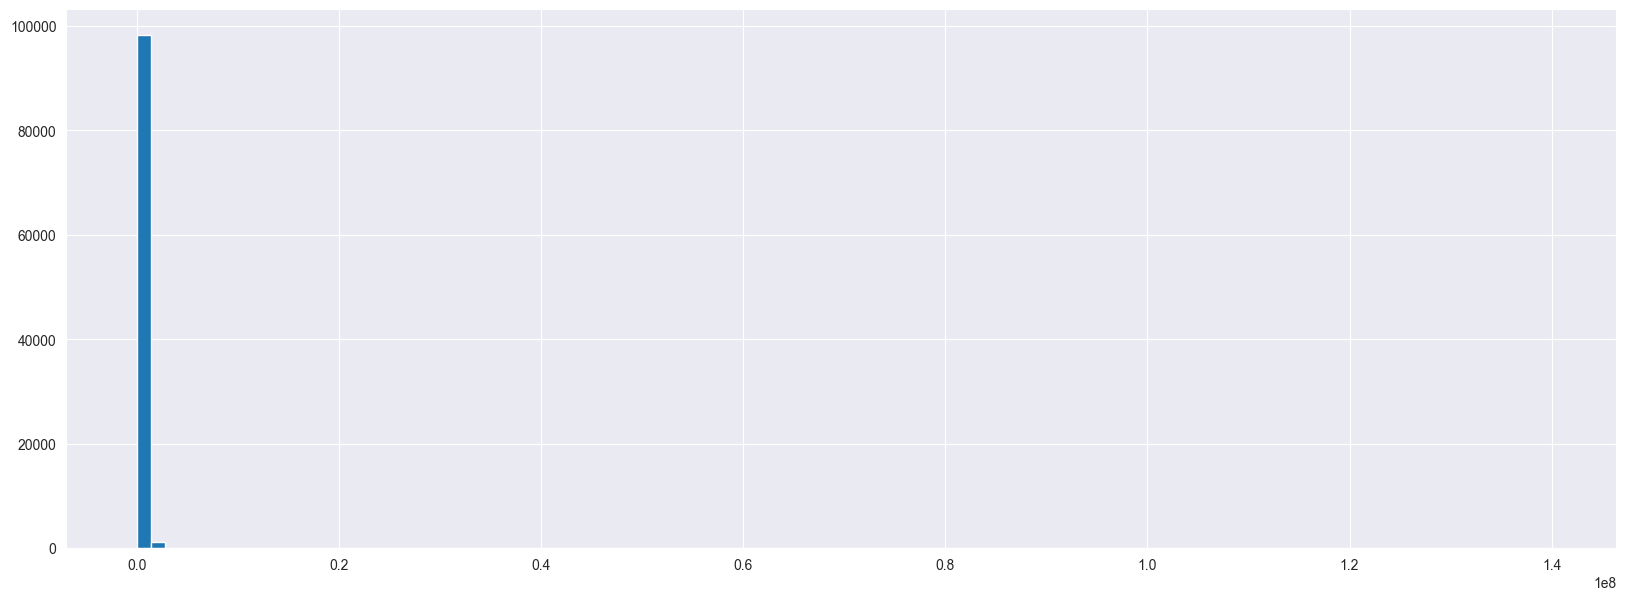

In [14]:
df.price_for_sq_m.hist(bins=100, figsize=(20,7))
plt.show()

Some flats have a price over 1_000_000 per sq.meter. Let's look closer

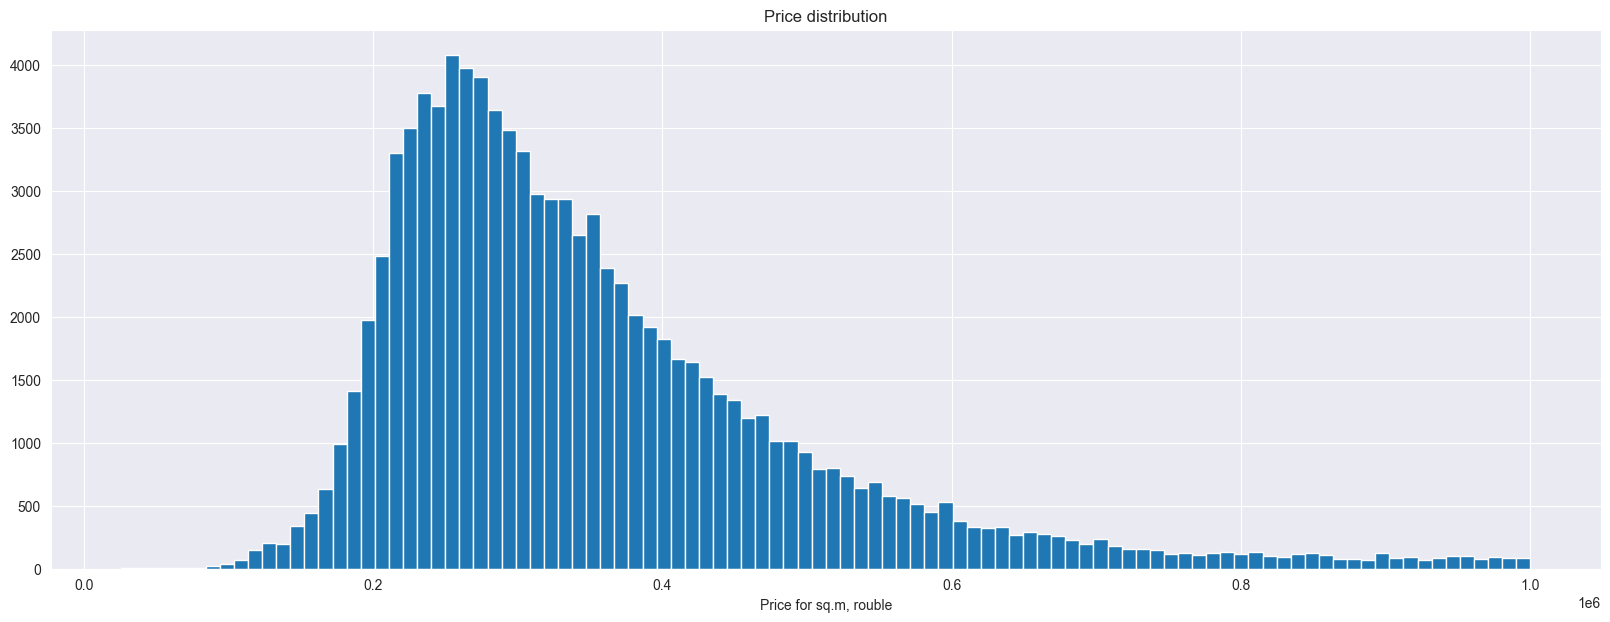

In [15]:
df.query('price_for_sq_m < 1_000_000 and flat_type != "share"').price_for_sq_m.hist(bins=100, figsize=(20,7))
plt.title('Price distribution')
plt.xlabel('Price for sq.m, rouble')
# plt.xticks([100000*i for i in range(10)])
plt.show()

Lets also look at distributions by districts

In [16]:
# df.query('price_for_sq_m < 1_000_000 and flat_type != "share"')\
#     .groupby('district')['price_for_sq_m']\
#     .plot(kind='hist', alpha=0.5, legend=True, bins=100, figsize=(25,10))

# # Настройка осей и заголовка
# plt.xlabel('Price for sq.m, rouble')
# plt.ylabel('Frequency')
# plt.title('Price distributions by district')

# # Отображение гистограммы
# plt.show()

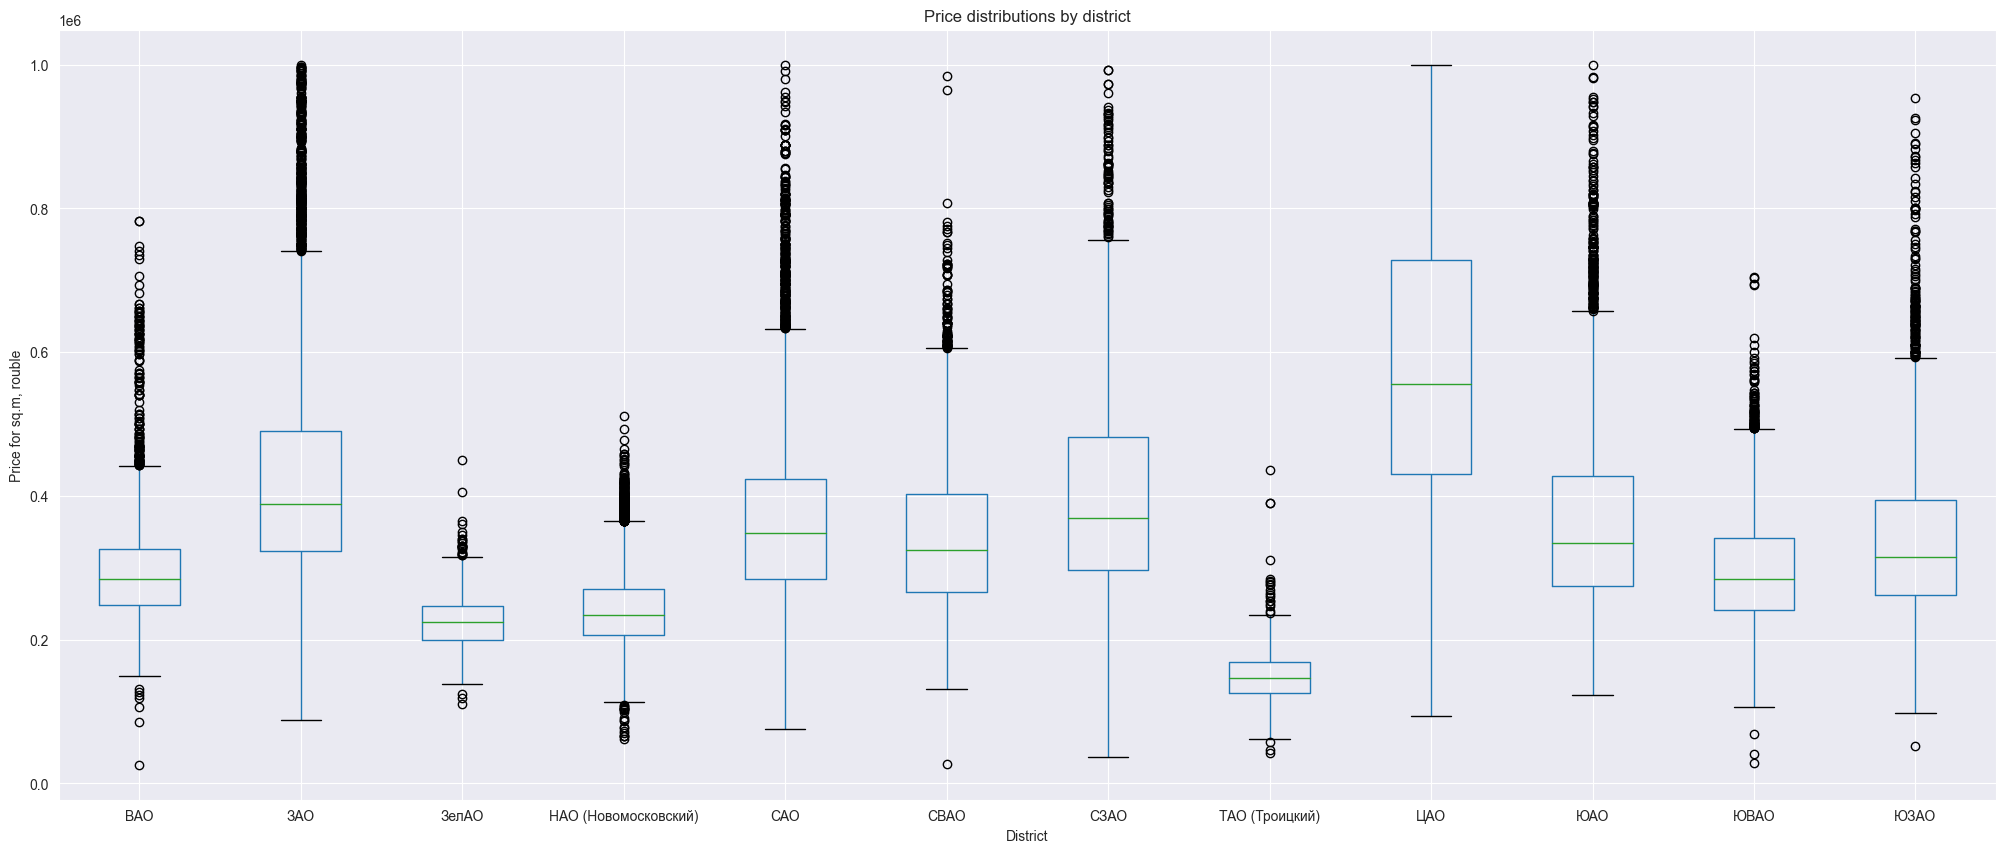

In [17]:
df.query('price_for_sq_m < 1_000_000 and flat_type != "share"')\
    .pivot_table(index='link', values='price_for_sq_m', columns='district', aggfunc='last')\
    .boxplot(figsize=(25,10))

plt.xlabel('District')
plt.ylabel('Price for sq.m, rouble')
plt.title('Price distributions by district')
plt.show()

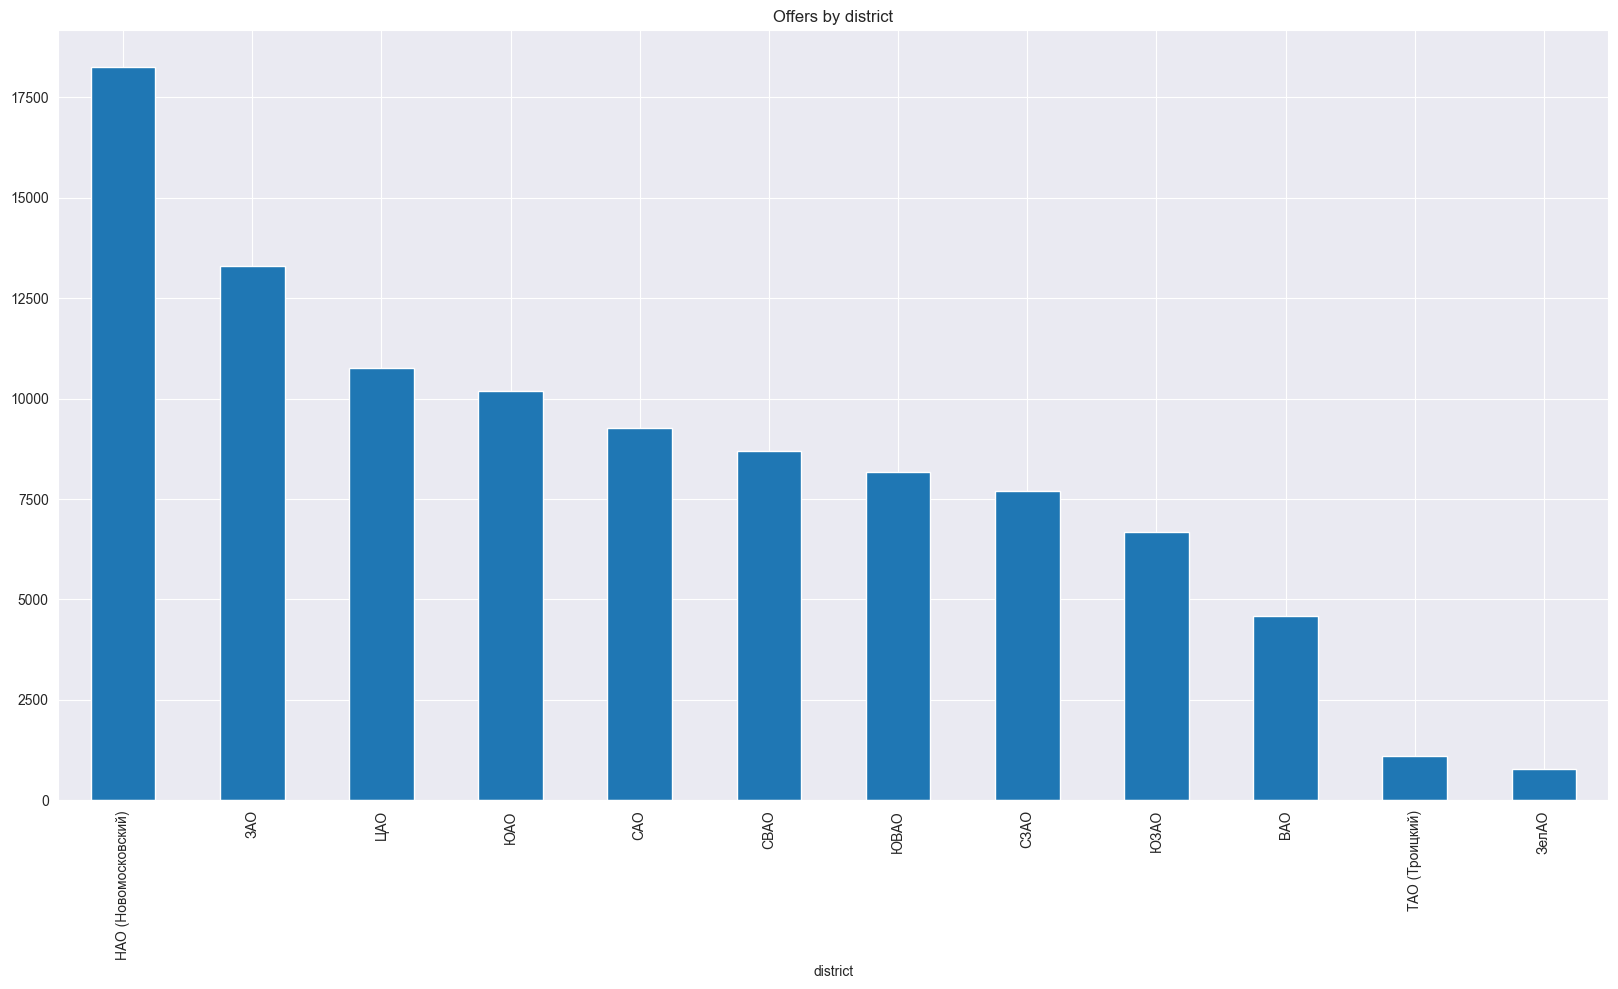

In [18]:
df.pivot_table(index='district', aggfunc='count')['city'].sort_values(ascending=False).plot(kind='bar',figsize=(20,10))
plt.title('Offers by district')
plt.show()

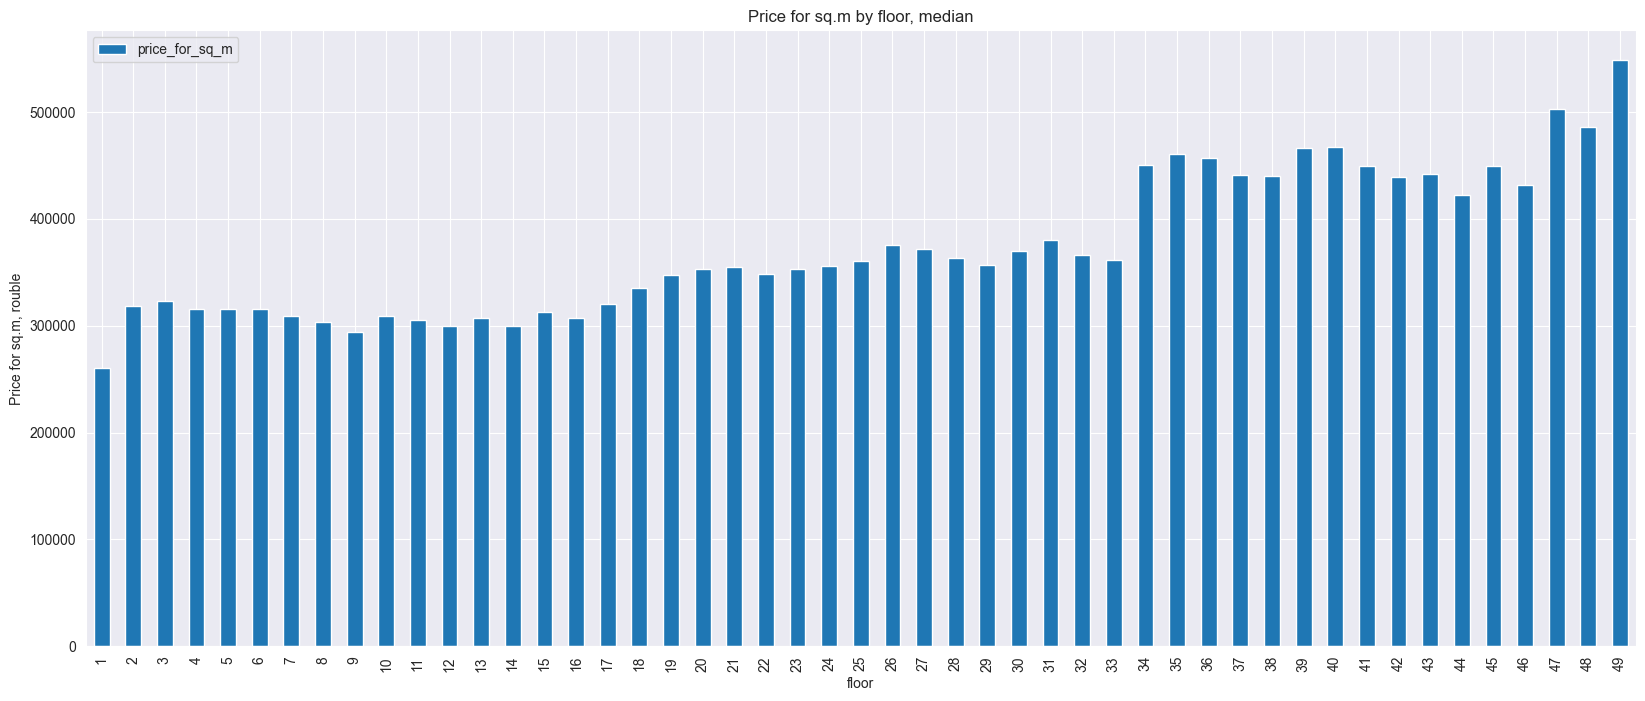

In [19]:
df[df['flat_type'] != 'share']\
    .pivot_table(index='floor', values='price_for_sq_m', aggfunc='median')\
    .plot(kind='bar', figsize=(20,8))
plt.title('Price for sq.m by floor, median')
plt.ylabel('Price for sq.m, rouble')
plt.show()

Geocoding

In [20]:
df.loc[df['metro'] == 'Библиотека им. Ленина','metro'] = 'Библиотека имени Ленина'

In [21]:
metro_names = df.metro.dropna().unique()
metro_names[:5]

array(['Площадь Революции', 'Волжская', 'Петровский Парк', 'Кунцевская',
       'Коптево'], dtype=object)

In [22]:
geolocator = Nominatim(user_agent="my_geocoder")

Uncomment this code if you want to geocode all metro stations yourself

In [23]:
# locations = {}
# for i, metro_name in enumerate(metro_names):
#     time.sleep(2)
#     location = geolocator.geocode(metro_name, 
#                                   bounded=True,  
#                                   viewbox=[Point(56.2,36.6),Point(55,38.2)]
#                                  )
#     print(f'\r Обрабатывается локация {i}', end='')
#     if location:
#         locations[metro_name] = [location[0], location[1]]
#     else:
#         locations[metro_name] = None
# #         time.sleep(2)
# #         location = geolocator.geocode('метро ' + metro_name + ' Москва')
# #         if location:
# #             locations[metro_name] = [location[0], location[1]]
# #         else:
# #             locations[metro_name] = None

In [24]:
# with open('datasets/metro_locations.json', 'w') as file:
#     json.dump(locations, file)

In [25]:
with open('datasets/metro_locations.json') as f:
    locations = json.load(f)

In [26]:
pd.DataFrame(locations).T.isna().sum()

0    0
1    0
dtype: int64

In [27]:
m = folium.Map(location=[55.751999,37.617734], zoom_start=11)

In [28]:
tmp = df.query('flat_type != "share"').groupby('metro')['price_for_sq_m'].agg('median')

In [29]:
def invert_colormap(cmap):
    colors = cmap.colors[::-1]  # inverse colors
    return cm.LinearColormap(colors, vmin=cmap.vmin, vmax=cmap.vmax)

In [30]:
colormap = cm.linear.RdYlGn_04.scale(50_000, 600_000)
price_cmap = invert_colormap(colormap)
price_cmap.caption='Price for sq.m'
price_cmap.width = 700
price_cmap.tick_labels = [i for i in range(50_000,600_001,50_000)]

In [31]:
m = folium.Map(location=[55.751999,37.617734], zoom_start=11)
price_cmap.add_to(m)
for k, v in locations.items():
    if v:
        hexagon = folium.RegularPolygonMarker(
            location=v[1],
            fill_color=price_cmap(tmp[k]),
            fill_opacity=0.9,
            number_of_sides=6,
            radius=12,
            tooltip=k
        )
        hexagon.add_to(m)


In [32]:
m

In [33]:
m.save('map.html')